# Red Neuronal en PyTorch

En este notebook veremos como crear una red neuronal usando PyTorch

In [2]:
# Primero llamamos a los paquetes necesarios
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

## Dataset

Ahora lo que necesitamos es un conjunto de datos (dataset). Afortunadamente el paquete **torchvision** provee un conjunto de datos de ejemplo. Utilizaremos MNIST, el cual contiene ejemplos de letras escritas a mano. El siguiente código lee el conjunto de datos y lo separa en un conjunto de entrenamiendo y uno de prueba. 

In [15]:
# Generaramos una transformación para normalizar el conjunto de datos
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5]),
                             ])
# Descargamos el conjunto de datos de entrenamiento
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
# Cargamos el conjunto
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Descargamos y cargamos el conjunto de prueba
testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [16]:
# Ordenamos los datos para tener parejas de imagenes con su respectiva clase

# Los datos se encuentran en trainloader asi que generamos un iterador para extraerlos uno por uno
dataiter = iter(trainloader)
images, labels = next(dataiter)

Es recomendable verificar que estamos cargando bien el conjunto de datos.

torch.Size([1, 28, 28])

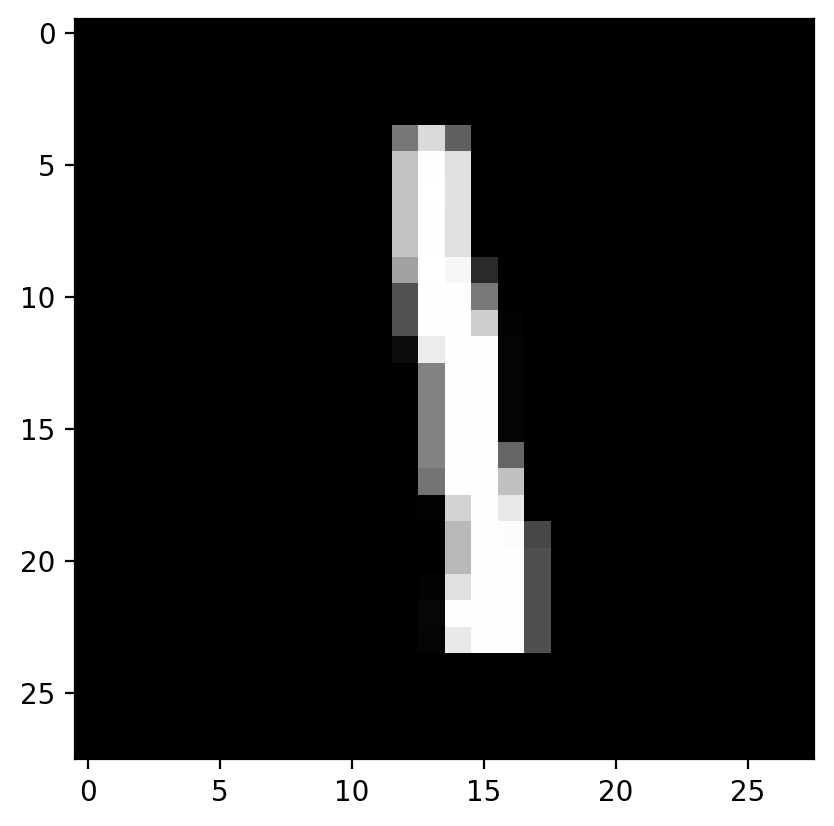

In [17]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');
images[1].size()

# Creación de la red neuronal

Ahora pasaremos a la creación de la red neuronal, como ejemplo utilizaremos una red completamente conectada (fully connected) para clasificar las imagenes de MNIST. Como entrada tendremos 784 nodos = 28 * 28, en seguida tendremos una capa oculta de 128 nodos, con una función de activación tipo RELU, despúes tendremos una segunda capa oculta con 64 nodos y función de activación RELU, en seguida tendremos 10 nodos de salida los cuales pasan por una función softmax que convierte los valores a probabilidades. Finalmente calculamos la pérdida (loss) con la función de entropía cruzada. 

<img src="archivos/net.png">

El modulo que contiene las herramientas para crear la RN es **pytorch.nn**. La red neuronal en sí se crea como una clase que hereda la estructura de **pytorch.nn.Module**. Cada una de las capas de la red se define de forma independiente. e.g. Para crear una capa con 784 entradas y 128 nodos utilizamos *nn.Linear(784, 128)*

La red implementa la función *forward* que realiza el paso frontal (fowdward pass). Esta función miembro recibe un tensor como emtrada y calcula la salida de la red. 

Varias funciones de activación se encuntran en el módulo *nn.functional*. Dicho módulo usualmente se importa como *F*. 


In [18]:
# importamos paquetes de pytorch

from torch import nn
from torch import optim
import torch.nn.functional as F

In [19]:
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        # Definir las capas. Cada una con 128, 64 y 10 unidades respectivamente
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        # Capa de salida con 10 units (una para cada dígito)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        ''' Pase frontal de la red, regresamos las probabilidades '''
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        
        return x

model = RedNeuronal()
model

RedNeuronal(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

### Inicializamos pesos y sesgos

Cuando creas las capas se crean también los tensores correspondientes a los pesos y sesgos. Éstos son inicializados por ti, aunque pudes modificarlos usando funciones extra. Para observar sus valores puedes llamar a *model.fc1.weight* 


In [20]:
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[ 0.0218, -0.0349,  0.0204,  ...,  0.0039,  0.0354, -0.0167],
        [ 0.0084,  0.0007, -0.0100,  ..., -0.0194, -0.0235, -0.0029],
        [-0.0035,  0.0152, -0.0053,  ..., -0.0068, -0.0211,  0.0168],
        ...,
        [-0.0218,  0.0327,  0.0087,  ..., -0.0017, -0.0190,  0.0066],
        [-0.0292, -0.0078,  0.0066,  ...,  0.0263, -0.0326,  0.0077],
        [-0.0152, -0.0091, -0.0117,  ..., -0.0210,  0.0257,  0.0238]],
       requires_grad=True)
Parameter containing:
tensor([-0.0315,  0.0287, -0.0271, -0.0135,  0.0349, -0.0153, -0.0253,  0.0131,
        -0.0047,  0.0240,  0.0173, -0.0183, -0.0043,  0.0214,  0.0234, -0.0158,
        -0.0088, -0.0028,  0.0092,  0.0311,  0.0208, -0.0172, -0.0004, -0.0028,
         0.0123,  0.0031,  0.0096, -0.0258, -0.0019,  0.0278,  0.0159, -0.0112,
        -0.0326, -0.0043,  0.0312,  0.0066,  0.0098, -0.0153,  0.0137,  0.0313,
        -0.0165, -0.0327,  0.0084,  0.0272, -0.0051,  0.0006, -0.0230,  0.0031,
         0.0307

Supongamos que deseamos inicializar los pesos con algunos valores personalizados. Dado que los pesos y sesgos en sí son variables de autograd (optimizador) necesitamos convertirlos a tensores para poder modificarlos.

In [21]:
# Colocamos ceros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# muestreamos desde una distribución normal con media cero y desv. estandar = 0.01
model.fc1.weight.data.normal_(std=0.01)

### Pase frontal

Hasta el momento la red no está entrenada y solo tenemos los pesos aleatorios. Hagamos un pase frontal para ver que pasa. Primero debemos convertir la imagen a un tensor y pasarla a través de la red. 

In [ ]:
# Obtengamos el siguiente valor 
#dataiter = iter(trainloader)
images, labels = dataiter.next()

# Reestructuremos la imagen a un vector de una dimensión, hay quie le llama a esta operación "aplanado".
# La nueva forma será (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# alternativa: images.resize_(images.shape[0], 1, 784) to not automatically get batch size

# Pase frontal de la red
img_idx = 0
ps = model.forward(images[img_idx,:])

print(ps)

In [ ]:
img = images[img_idx]
helper.view_classify(img.view(1, 28, 28), ps)

Muy probablemente ninguna de las clases tiene una probabilidad grande con respecto de las otras, esto se debe a que todavía no hemos entrenado la red. En el siguiente ejercicio entrenaremos la red.
